# Prepare data for recommender systems and train the model

## Load modules

In [1]:
# This ensures all modules are re-imported when import is called. This is useful for easier development and debugging.
%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [2]:
# Import NumPy, pandas, matplotlib and PyTorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Import sklearn modules
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Import Utility Functions
from datetime import datetime
import pickle

# Import custom modules
from modelling.dataset import ZRM_ReccomenderDataset
from modelling.ncf import ZRM_Reccomender
from modelling.preprocessing import feature_engineering, get_bin_labels, train_test_split_coild
from modelling.utils import EarlyStopping

from tqdm import tqdm
from crecsys import ZRMrecsys

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # a CUDA device object
    print("Training on GPU")
else:
    device = torch.device("cpu")
    print("Training on CPU")

Training on CPU


# Data preparation

In [72]:
# Load preprocessed data
df = pd.read_pickle('data/dataset.pkl')

In [36]:
df = feature_engineering(df)

## Feature selection (manual) - optional

In [134]:
from scipy.stats import spearmanr
from tqdm import tqdm
from sklearn.feature_selection import f_regression, SelectKBest


In [135]:
X = df.drop(columns=['EXIT_THICK_DEVIATION_ABS_AVG', 'class', 'coil_id'])
y = df[['EXIT_THICK_DEVIATION_ABS_AVG']]

In [136]:
fs = SelectKBest(score_func=f_regression, k=15)
fs.fit(X,y)
cols_idxs = fs.get_support(indices=True)
X_selected = X.iloc[:,cols_idxs]

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [137]:
X_selected.columns

Index(['pass_nr', 'tension_ex', 'h_exit_ref', 'h_entry_ref', 'dh_entry_std',
       'dh_entry_min', 'velocity_en', 'velocity_en_max', 'velocity_en_med',
       'h_entry', 'h_entry_min', 'h_entry_max', 'h_entry_std', 'h_reduced',
       'h_reduction'],
      dtype='object')

In [138]:
for i, name in tqdm(enumerate(X.columns.values)):
    coef, p = spearmanr(X.values[:, i], y.values)
    df_spearman_l = pd.DataFrame((np.concatenate((name, coef, p), axis=None).reshape(1,-1)),
                columns=['feature', 'coef', 'p'])
    try:
        df_spearman = df_spearman.append(df_spearman_l, ignore_index=True)
    except:
        df_spearman = df_spearman_l
df_spearman.set_index('feature', inplace=True)

"""df_spearman.drop(index='mat_class_ex', inplace=True)
df_spearman.drop(index='pass_nr_ex', inplace=True)
df_spearman.drop(index='nr_passes_ex', inplace=True)
df_spearman.drop(index='coil_width_ex', inplace=True)"""
df_spearman['coef'] = pd.to_numeric(df_spearman['coef'])
df_spearman['p'] = pd.to_numeric(df_spearman['p'])
df_spearman = df_spearman.iloc[df_spearman.coef.abs().argsort()[::-1]]

63it [00:05, 11.51it/s]


In [139]:
df_spearman

,coef,p
feature,,
dh_entry_std,0.905088,0.000000e+00
h_entry_std,0.905088,0.000000e+00
pass_nr,-0.814436,0.000000e+00
h_exit_ref,0.803150,0.000000e+00
h_entry_max,0.797099,0.000000e+00
tension_ex,0.787598,0.000000e+00
h_entry_ref,0.776786,0.000000e+00
h_entry,0.776532,0.000000e+00
h_reduction,0.776357,0.000000e+00


In [140]:
sc = MinMaxScaler()
X_sc = sc.fit_transform(X)


In [141]:
for i, name in tqdm(enumerate(X.columns.values)):
    coef, p = spearmanr(X_sc[:, i], y.values)
    df_spearman_l = pd.DataFrame((np.concatenate((name, coef, p), axis=None).reshape(1,-1)),
                columns=['feature', 'coef', 'p'])
    try:
        df_spearman = df_spearman.append(df_spearman_l, ignore_index=True)
    except:
        df_spearman = df_spearman_l
df_spearman.set_index('feature', inplace=True)

"""df_spearman.drop(index='mat_class_ex', inplace=True)
df_spearman.drop(index='pass_nr_ex', inplace=True)
df_spearman.drop(index='nr_passes_ex', inplace=True)
df_spearman.drop(index='coil_width_ex', inplace=True)"""
df_spearman['coef'] = pd.to_numeric(df_spearman['coef'])
df_spearman['p'] = pd.to_numeric(df_spearman['p'])
df_spearman = df_spearman.iloc[df_spearman.coef.abs().argsort()[::-1]]

2it [00:00, 13.88it/s]

21it [00:02, 10.57it/s]

In [ ]:
df_spearman

In [ ]:
df[['h_entry']].plot()
pd.DataFrame((df['h_entry_ref'] + df['dh_entry'])).plot()

## Feature selection (SHAP) - optional

In [ ]:
df_train, df_test = train_test_split_coild(df, train_ratio=0.8, random_state=42)


In [ ]:
sc = MinMaxScaler()
drop_columns = ['EXIT_THICK_DEVIATION_ABS_AVG', 'class', 'coil_id', 'EXIT_THICK_DEVIATION_AVG', 'index', 'pass_nr1', 'pass_nr2', 'pass_nr3', 'pass_nr4', 'velocity_en', 'velocity_en_max',
       'velocity_en_min', 'velocity_en_med', 'velocity_en_std', 'velocity_ex_std', 'velocity_ex',
       'velocity_ex_max', 'velocity_ex_min', 'velocity_ex_med']
X_train = df_train.drop(columns=drop_columns)
y_train = df_train[['EXIT_THICK_DEVIATION_ABS_AVG']]
X_test = df_test.drop(columns=drop_columns)
y_test = df_test[['EXIT_THICK_DEVIATION_ABS_AVG']]

In [ ]:
X_train_sc = sc.fit_transform(X_train)
y_train = y_train.values.ravel()
X_test_sc = sc.transform(X_test)
y_test = y_test.values.ravel()
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()


In [ ]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.01, 
                              n_estimators=1000, 
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin = 55, 
                              verbose=1)

In [ ]:
model_lgb.fit(X_train_sc, y_train)


In [ ]:
pred = model_lgb.predict(X_test_sc)


In [ ]:
plt.scatter(pred, y_test)
plt.plot([0,10], [0,10])
plt.xlabel('true')
plt.ylabel('pred')
from sklearn.metrics import r2_score, mean_absolute_error
r2_score(pred, y_test), mean_absolute_error(pred, y_test)

In [ ]:
!pip install shap

In [ ]:
import shap


In [ ]:
# load JS visualization code to notebook
shap.initjs()

In [ ]:
pd.DataFrame(X_train_sc, columns=X_train.columns).pass_nr.value_counts()

In [ ]:
# Using a random sample of the dataframe for better time computation
X_sampled = pd.DataFrame(X_train_sc, columns=X_train.columns).sample(1000, random_state=10)

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_sampled)

In [ ]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

In [ ]:
# visualize the training set predictions
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, X_train)

In [ ]:
shap.summary_plot(shap_values, X_sampled, max_display=X_sampled.shape[1])

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar", max_display=X_sampled.shape[1])


In [ ]:
grouped = df_train.groupby('class')
grouped.mean().T

## Select desired features

In [37]:
coil_columns = [ 'h_entry',
                'h_entry_std',
                'h_entry_min',
                'h_entry_max',
                'h_exit_ref',
                'h_reduced',
                'h_reduction',
                'AL',
                'CU']    

recipe_columns = ['tension_en',
                  'tension_ex',
                  'velocity_mdr']
quality_column = 'EXIT_THICK_DEVIATION_ABS_AVG'

In [38]:
df = df[['coil_id', 'pass_nr', 'class']+coil_columns+recipe_columns+[quality_column]]

## "Signing policy"

### Binarize data

In [39]:
df_bin = df[coil_columns+recipe_columns].copy()

In [40]:
bin_nr = 10
categorizers = {}
for column in coil_columns:
  #df_bin[column] = pd.cut(df[column].values, bin_nr, ordered=False, labels=False)
  bin_categories = pd.cut(df[column].values, bin_nr).categories
  #bin_categories = pd.qcut(df[column].values, bin_nr, duplicates='drop').categories
  df_bin[column] = get_bin_labels(df[column].values, bin_categories, padding=2)
  categorizers[column] = bin_categories # Save for further use

bin_nr = 10
for column in recipe_columns:
  #df_bin[column] = pd.cut(df[column].values, bin_nr, ordered=False, labels=False)
  bin_categories = pd.cut(df[column].values, bin_nr).categories
  #bin_categories = pd.qcut(df[column].values, bin_nr, duplicates='drop').categories
  df_bin[column] = get_bin_labels(df[column].values, bin_categories, padding=2)
  categorizers[column] = bin_categories # Save for further use

with open("engine/categorizers.pickle", "wb") as f:
    pickle.dump(categorizers, f)

### Coil and recipe segmentation

In [41]:
# Calculate coil and recipe index from other binarized columns
#     'a' 'b' 'c'  'idx'
#      02   03	 10  020310

df_bin['coil_similar_idx'] = df_bin[coil_columns].astype(str).apply(lambda x: ''.join(x), axis=1)
df_bin['recipe_similar_idx'] = df_bin[recipe_columns].astype(str).apply(lambda x: ''.join(x), axis=1)

# Convert derived indices from 0 to N (create lookup table)
coil_dict = {mid: i for i, mid in enumerate(df_bin['coil_similar_idx'].unique())}
recipe_dict = {pid: i for i, pid in enumerate(df_bin['recipe_similar_idx'].unique())}

# Convert derived indices from 0 to N (actual conversion)
df_bin['coil_idx'] = ([coil_dict[mid] for mid in df_bin['coil_similar_idx']])
df_bin['recipe_idx'] = ([recipe_dict[pid] for pid in df_bin['recipe_similar_idx']])

bin_features_columns = ['coil_idx', 'recipe_idx'] + coil_columns + recipe_columns
df_bin = df_bin[bin_features_columns]



In [42]:
# Save lookup table for coil/recipe indices
with open("engine/coil_dict.pickle", "wb") as f:
    pickle.dump(coil_dict, f)
with open("engine/recipe_dict.pickle", "wb") as f:
    pickle.dump(recipe_dict, f)

In [43]:
features_sizes = {}
# Generate key-value pairs in a loop and add them to the dictionary
for column in df_bin.columns:
    key = column
    value = df_bin[column].max()
    features_sizes[key] = value

In [44]:
# Save corresponding actual coil_id to binarized DataFrame
df_bin['coil_id'] = df['coil_id'].values
df_bin[quality_column] = df[quality_column].values

# Save derived coil to binarized DataFrame
df['coil_idx'] = df_bin['coil_idx'].values
df['recipe_idx'] = df_bin['recipe_idx'].values

In [45]:
with open("engine/data/RecSysData.pickle", "wb") as f:
    pickle.dump(df, f)

## Data preprocessing

In [46]:
numeric_cols = df.select_dtypes(include='number').columns.values
df_a = df.groupby(['coil_id', 'pass_nr'])


# Define aggregation functions for different columns
agg_functions = {col: 'median' for col in numeric_cols}
agg_functions['class'] = 'last'
agg_functions['coil_id'] = 'last'
# Apply aggregation functions to the grouped DataFrame
df_a = df_a.agg(agg_functions).reset_index(drop=True)

In [47]:
# Split dataset based on coil_id
df_train, df_test = train_test_split_coild(df_a, train_ratio=0.8, random_state=0)
df_train = df_train.drop(columns=['coil_id'])
df_test = df_test.drop(columns=['coil_id'])

In [48]:

# Coil features scaling
sc_coil = MinMaxScaler()
df_train[coil_columns] = sc_coil.fit_transform(df_train[coil_columns])
df_test[coil_columns] = sc_coil.transform(df_test[coil_columns])
with open("engine/sc_coil.pickle", "wb") as f:
    pickle.dump(sc_coil, f)

# Recipe features scaling
sc_recipe = MinMaxScaler()
df_train[recipe_columns] = sc_recipe.fit_transform(df_train[recipe_columns])
df_test[recipe_columns] = sc_recipe.transform(df_test[recipe_columns])
with open("engine/sc_recipe.pickle", "wb") as f:
    pickle.dump(sc_recipe, f)


In [49]:

# set up data
train_dataset = ZRM_ReccomenderDataset(df_train, coil_columns, recipe_columns, quality_column)
test_dataset = ZRM_ReccomenderDataset(df_test, coil_columns, recipe_columns, quality_column)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


# Modelling

In [50]:
# define the input and output dimensions
nr_coil_features = len(coil_columns)  # columns that represent coil (user)
nr_recipe_features = len(recipe_columns)  # columns that represent recipe (item)

In [51]:
from modelling.ncf import ZRM_Reccomender

In [52]:
PATH = "engine/model_fm_mlp.pt"
model = ZRM_Reccomender(features_sizes['coil_idx']+1, features_sizes['recipe_idx']+1, nr_coil_features, nr_recipe_features, n_factors=20)
model.to(device)


ZRM_Reccomender(
  (coil_embeddings): Embedding(1205, 20)
  (recipe_embeddings): Embedding(198, 20)
  (coil_bias): Embedding(1205, 1)
  (recipe_bias): Embedding(198, 1)
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=16, out_features=8, bias=True)
      (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (mlp_ensemble): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=28, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=8, out_features=4, bias=True)
      (5): B

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
early_stopping = EarlyStopping(patience=5, verbose=True, path=PATH)

## Training

In [54]:
model = model.to(device)

In [55]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
test_losses = []

# train the model
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for coil_indices, recipe_indices, coil_features, recipe_features, ratings in train_dataloader:
        optimizer.zero_grad()

        coil_indices = coil_indices.to(device)
        recipe_indices = recipe_indices.to(device)
        coil_features = coil_features.to(device)
        recipe_features = recipe_features.to(device)
        ratings = ratings.to(device)
        predictions = model(coil_indices, recipe_indices, coil_features, recipe_features)
        loss = loss_fn(predictions, ratings)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(ratings)
    train_loss /= len(train_dataset)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for coil_indices, recipe_indices, coil_features, recipe_features, ratings in test_dataloader:

            coil_indices = coil_indices.to(device)
            recipe_indices = recipe_indices.to(device)
            coil_features = coil_features.to(device)
            recipe_features = recipe_features.to(device)
            ratings = ratings.to(device)
            predictions = model(coil_indices, recipe_indices, coil_features, recipe_features)
            loss = loss_fn(predictions, ratings)
            test_loss += loss.item() * len(ratings)
        test_loss /= len(test_dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(test_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")
    
model = model.to("cpu")

Validation loss decreased (inf --> 2.731032).  Saving model ...
Epoch 1: Train Loss=11.0775, Test Loss=2.7310
Validation loss decreased (2.731032 --> 1.904013).  Saving model ...
Epoch 2: Train Loss=4.0625, Test Loss=1.9040
Validation loss decreased (1.904013 --> 1.641947).  Saving model ...
Epoch 3: Train Loss=3.4126, Test Loss=1.6419
Validation loss decreased (1.641947 --> 1.433801).  Saving model ...
Epoch 4: Train Loss=2.9071, Test Loss=1.4338
Validation loss decreased (1.433801 --> 1.242159).  Saving model ...
Epoch 5: Train Loss=2.5102, Test Loss=1.2422
Validation loss decreased (1.242159 --> 1.198320).  Saving model ...
Epoch 6: Train Loss=2.3791, Test Loss=1.1983
Validation loss decreased (1.198320 --> 1.042858).  Saving model ...
Epoch 7: Train Loss=2.1326, Test Loss=1.0429
Validation loss decreased (1.042858 --> 0.851540).  Saving model ...
Epoch 8: Train Loss=1.8053, Test Loss=0.8515
EarlyStopping counter: 1 out of 5
Epoch 9: Train Loss=1.7739, Test Loss=0.8925
EarlyStopping

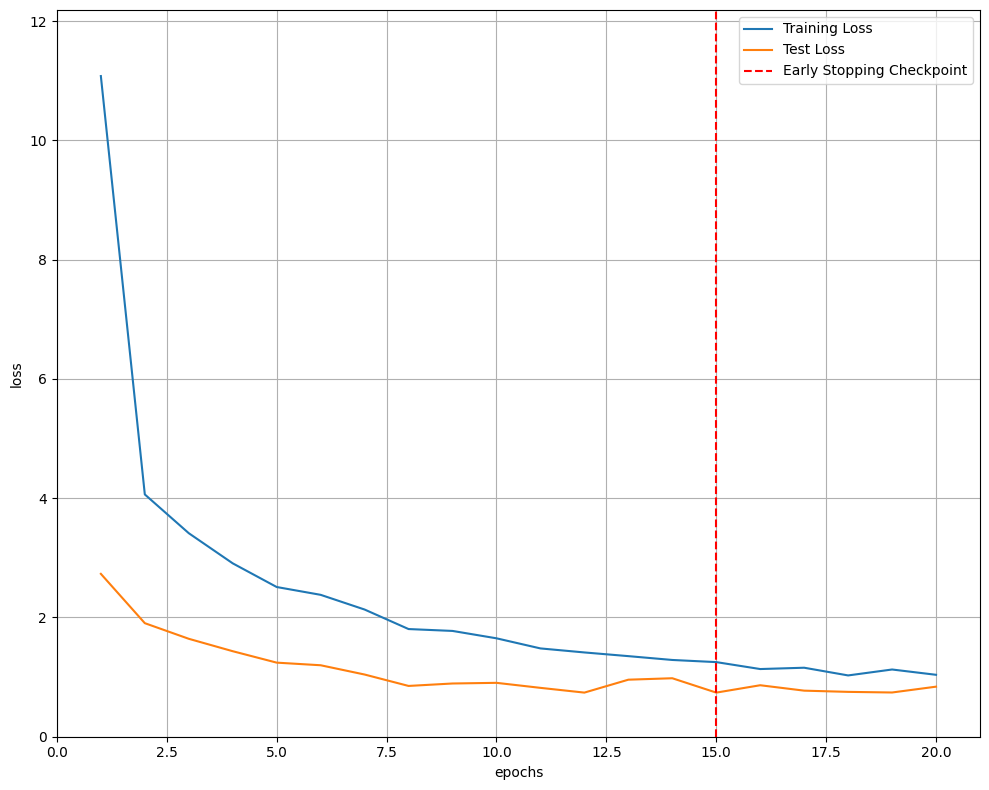

In [56]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(test_losses)+1),test_losses,label='Test Loss')

# find position of lowest validation loss
minposs = test_losses.index(min(test_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1.1*max(max(train_losses), max(test_losses))) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.show()
#fig.savefig('loss_plot.png', bbox_inches='tight')

## Save/Load model

In [57]:
# Load
model = torch.load(PATH)
model.eval()
model.to("cpu")

ZRM_Reccomender(
  (coil_embeddings): Embedding(1205, 20)
  (recipe_embeddings): Embedding(198, 20)
  (coil_bias): Embedding(1205, 1)
  (recipe_bias): Embedding(198, 1)
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=12, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=16, out_features=8, bias=True)
      (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
    )
  )
  (mlp_ensemble): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=28, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=8, out_features=4, bias=True)
      (5): B

## Manual prediction

In [67]:
iter_dataloader = (iter(test_dataloader))


In [68]:
coil_indices, recipe_indices, coil_features, recipe_features, ratings = next(iter_dataloader)
predictions = model(coil_indices, recipe_indices, coil_features, recipe_features)
predictions = predictions.detach().numpy()
ratings = ratings.detach().numpy()

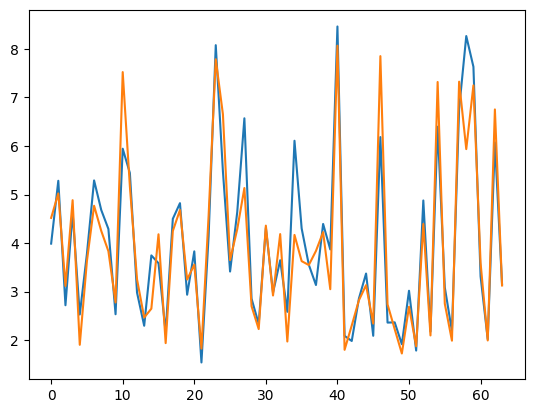

In [69]:
plt.plot(ratings)
plt.plot(predictions)


(0.8558531556589801, 0.4639787)

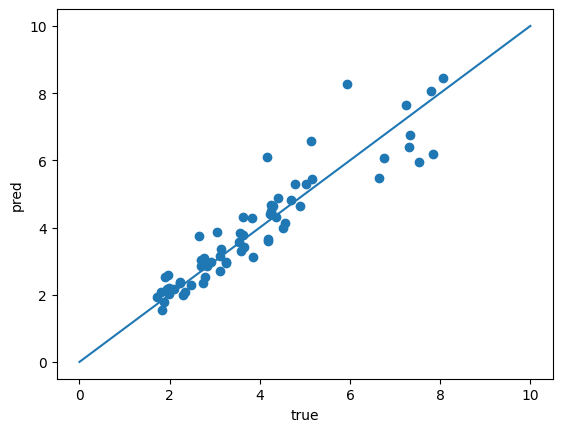

In [70]:
plt.scatter(predictions, ratings)
plt.plot([0, 10],[0, 10])
plt.xlabel('true')
plt.ylabel('pred')
from sklearn.metrics import r2_score, mean_absolute_error
r2_score(predictions, ratings), mean_absolute_error(predictions, ratings)

## Model validation


In [63]:
df = pd.read_pickle("data/dataset.pkl")

In [64]:
df_l = df.copy()
numeric_cols = df_l.select_dtypes(include='number').columns.values
df_l = df_l.groupby(['coil_id', 'pass_nr'])


# Define aggregation functions for different columns
agg_functions = {col: "median" for col in numeric_cols}
agg_functions['class'] = 'last'
agg_functions['coil_id'] = 'last'
# Apply aggregation functions to the grouped DataFrame
df_l = df_l.agg(agg_functions).reset_index(drop=True)

In [65]:
result = pd.DataFrame()
for i in tqdm(range(df_l.shape[0])):
  recsys_obj = ZRMrecsys()

  coil_df = df_l.iloc[[i]]


  new_coil, new_coil_idx = recsys_obj.preprocess_coil_data(coil_df)
  act_used = coil_df[['tension_en', 'tension_ex', 'velocity_mdr']].copy()
  act_used['pred'] = recsys_obj.predictQuality(act_used, new_coil, new_coil_idx)
  act_used['true'] = coil_df[['EXIT_THICK_DEVIATION_ABS_AVG']].copy()

  #act_used[['dh_entry', 'dh_entry_std', 'dh_entry_min', 'dh_entry_max']] = coil_df[['dh_entry', 'dh_entry_std', 'dh_entry_min', 'dh_entry_max']].copy()
  result = pd.concat([result,act_used])

result = result.reset_index(drop=True)

100%|██████████| 5806/5806 [01:41<00:00, 57.34it/s]


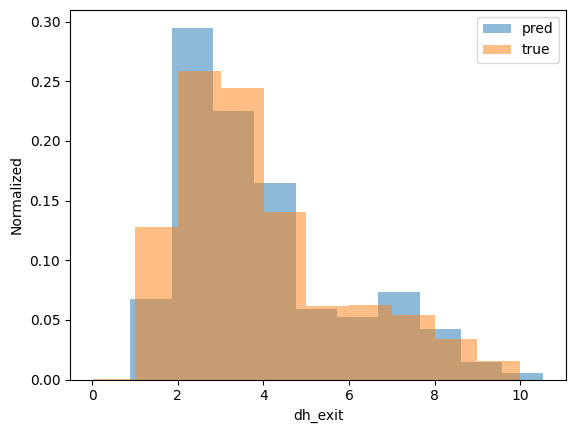

In [66]:
resulta = result.loc[result.true < 10]
fig, ax = plt.subplots()

for col in ['pred', 'true']:

  data = resulta[col]
  weights = np.ones_like(data)/float(len(data))
  ax.hist(data, weights=weights, bins=10, alpha=0.5, label=col)
  # set plot properties
  plt.legend()
  plt.xlabel('dh_exit')
  plt.ylabel('Normalized')

# show plot
plt.savefig("img/model_hist.png")
plt.show()

(0.920217744515738, 0.34609802236689635)

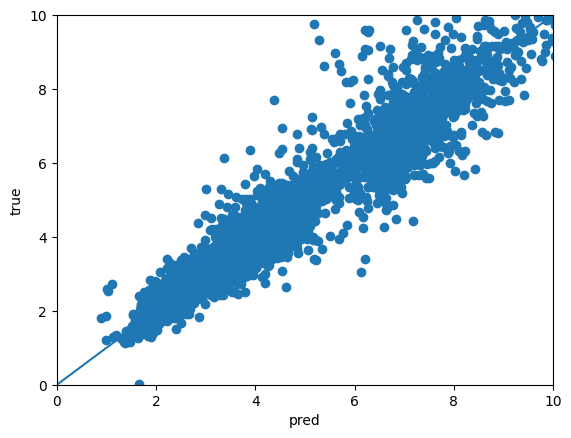

In [68]:
predictions = resulta['pred']
ratings = resulta['true']
plt.scatter(predictions, ratings)
plt.plot([0,10], [0,10])
plt.xlabel('pred')
plt.ylabel('true')
plt.savefig("img/modelRscore.png")

plt.xlim([0,10])
plt.ylim([0,10])

from sklearn.metrics import r2_score, mean_absolute_error
r2_score(predictions, ratings), mean_absolute_error(predictions, ratings)

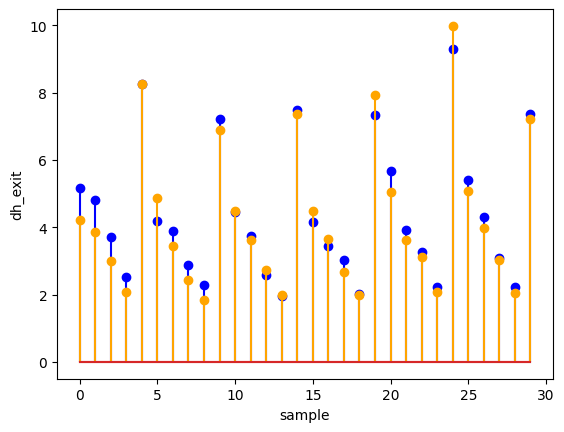

<Figure size 640x480 with 0 Axes>

In [69]:
plt.stem(ratings[120:150], 'blue')
plt.stem(predictions[120:150], 'orange')
plt.xlabel('sample')
plt.ylabel('dh_exit')
plt.savefig("img/model_pred.png")
fig = plt.figure()

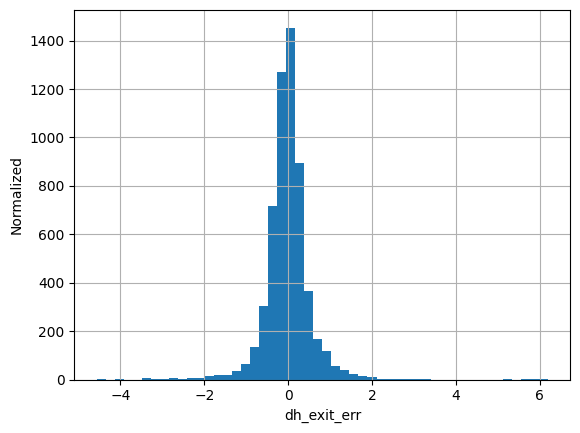

In [70]:
(resulta['pred'] - resulta['true']).hist(bins=50)

plt.xlabel('dh_exit_err')
plt.ylabel('Normalized')
plt.savefig("img/model_hist_error.png")